# Analysis of Monthly Mean Historical Hydrologic Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective analog simulation run using gridded observations -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Total Runoff
- ET

In [1]:
from loca import print_date
print_date()

Last executed: 2018-02-11 22:53:50.316127 by jhamman on r8i4n0


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_historical_hydro_datasets

models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
# models = ['CCSM4', 'CNRM-CM5']

hydro_vars = ['ET', 'total_runoff']

In [3]:
from dask.distributed import Client
client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client

Client Scheduler: tcp://10.148.7.109:44951 Dashboard: http://10.148.7.109:8787/status,Cluster Workers: 6 Cores: 24 Memory: 108.00 GB


# Load Data

In [4]:
hydro_data = load_monthly_historical_hydro_datasets(models=models, autoclose=True)

load_monthly_historical_hydro_datasets
load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology


100%|██████████| 6/6 [03:33<00:00, 35.57s/it]


load_monthly_bcsd_hydrology
load_bcsd_dataset


100%|██████████| 6/6 [05:51<00:00, 58.52s/it]


load_monthly_livneh_hydrology
load_daily_livneh_hydrology
load_monthly_maurer_hydrology


TypeError: open_dataset() got an unexpected keyword argument 'preproc'

In [ ]:
epoch = slice('1979-10-01', '1999-09-30')

mask = hydro_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, ds.sel(time=epoch).mean('time').where(mask).persist())
                   for (k, ds) in hydro_data.items())

# for debugging
# epoch_means = {}
# for k, ds in hydro_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

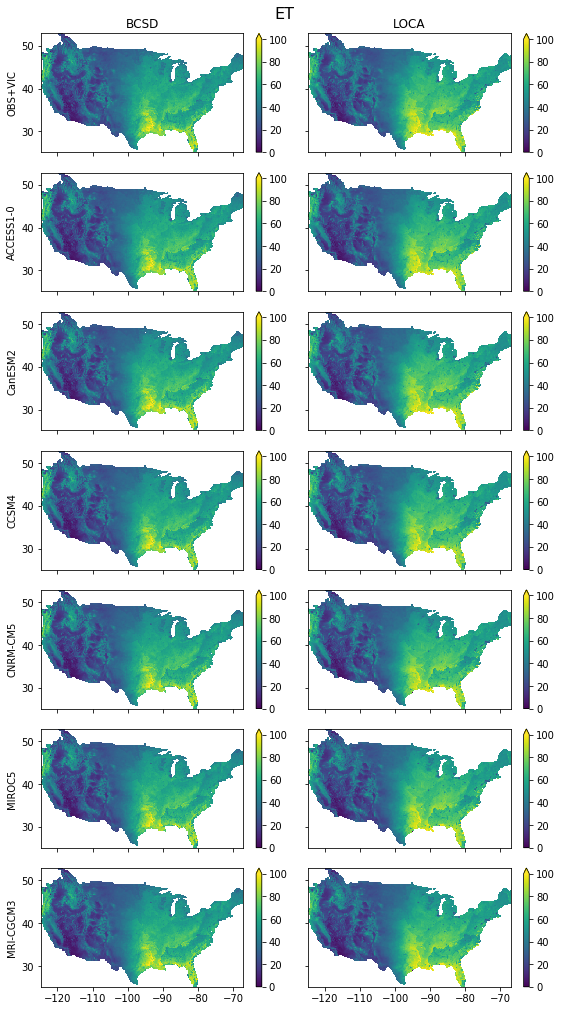

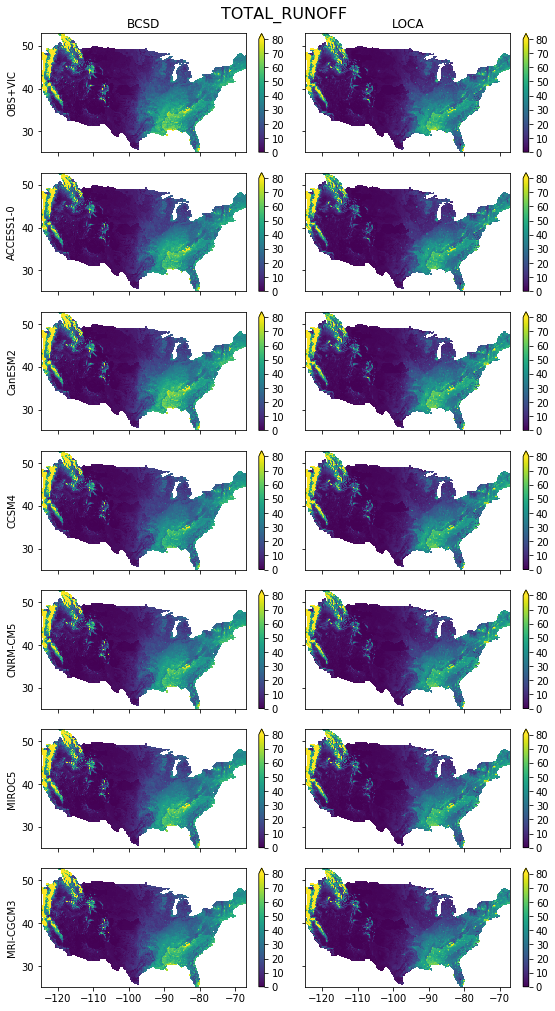

In [8]:
kwargs = {'ET': {'vmin': 0, 'vmax': 100},
          'total_runoff': {'vmin': 0, 'vmax': 80},}

# TODO: Fix mask issue with LOCA

nrows = 1 + len(models)
ncols = 2

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('OBS+VIC')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()     


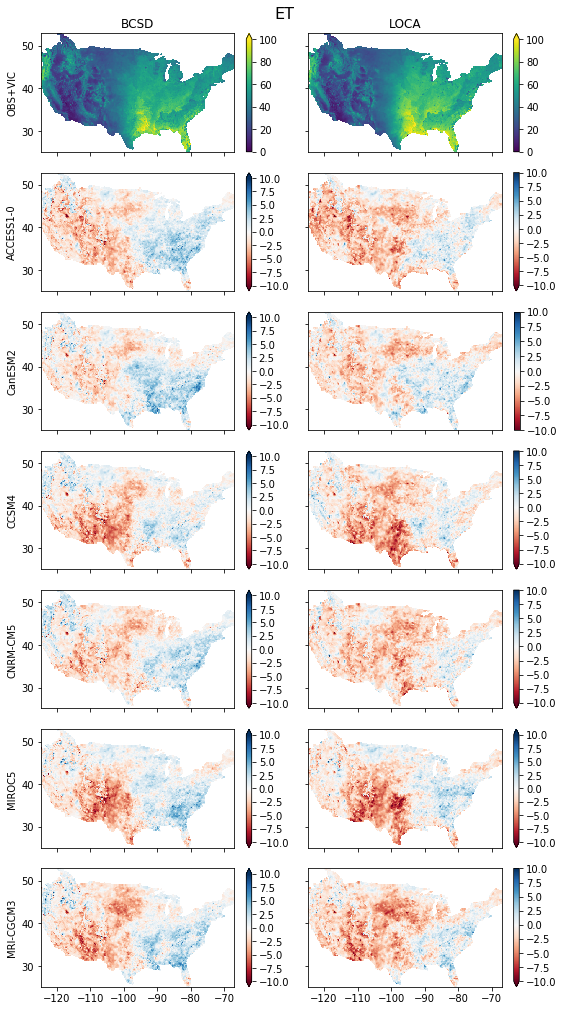

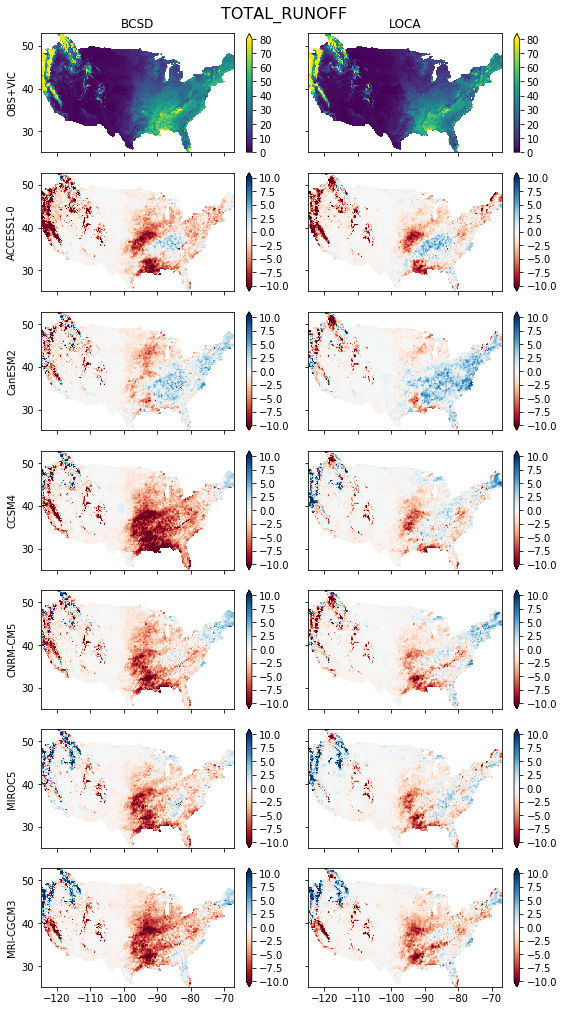

In [9]:
diff_kws = {'ET': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu'},
            'total_runoff': {'vmin': -10, 'vmax': 10, 'cmap': 'RdBu'}}

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
    
    for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):
        
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        
        if col == 0:
            ax.set_ylabel('OBS+VIC')
        
        ax.set_title(title)
        
        for row, model in enumerate(models, 1):
            ax = axes[row, col]
            (ds_data[var] - obs_data[var]).sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()  


In [ ]:
# cleanup 
plt.close('all')